In [1]:
import os
from langchain.embeddings.openai import OpenAIEmbeddings

In [2]:
env_vars = {
    "OPENAI_API_KEY": "",
}

In [3]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

for key, value in env_vars.items():
    os.environ[key] = value

embedding = OpenAIEmbeddings(chunk_size=1 )

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

from langchain.schema import Document

# Load blog post
from langchain.document_loaders import TextLoader, PyPDFLoader

In [9]:
loader = PyPDFLoader("./fda_guidelines/Considerations-Development-CAR-T-Cell-Products_March-2022.pdf")
data = loader.load()
loader = PyPDFLoader("./fda_guidelines/Long-Term-Follow-Up-After-Admin-Human-GT-Products_Jan_2020.pdf")
data2 = loader.load()

docs = data + data2

In [10]:
len(data)

39

In [13]:
data[0]

Document(page_content='Considerations for the Development of \nChimeric Antigen Receptor (CAR) T \nCell Product s \n \n \nDraft Guidance for Industry  \n \n \n \nThis guidance document is for comment purposes only.  \n \n    Submit one set of either electronic or written comments on this draft guidance by the date provided in the Federal Register  notice announcing the availability of the draft guidance.  \nSubmit electronic comments to http://www.regulations.gov\n.  Submit written comments to the \nDockets Management Staff (HFA -305), Food and Drug Administration, 5630 Fishers Lane, Rm. \n1061, Rockville, MD 20852.  You should identify all comments with the docket number listed in the notice of availability that publishes in the Federal Register . \n Additional copies of this guidance are available from the Office of Communication, Outreach and Development (OCOD), 10903 New Hampshire Ave., Bldg. 71, Rm. 3128, Silver Spring, MD 20993- 0002, or by calling 1- 800-835-4709 or 240- 402-801

In [14]:
pretty_print_docs(data)

Document 1:
Considerations for the Development of 
Chimeric Antigen Receptor (CAR) T 
Cell Product s 
 
 
Draft Guidance for Industry  
 
 
 
This guidance document is for comment purposes only.  
 
    Submit one set of either electronic or written comments on this draft guidance by the date provided in the Federal Register  notice announcing the availability of the draft guidance.  
Submit electronic comments to http://www.regulations.gov
.  Submit written comments to the 
Dockets Management Staff (HFA -305), Food and Drug Administration, 5630 Fishers Lane, Rm. 
1061, Rockville, MD 20852.  You should identify all comments with the docket number listed in the notice of availability that publishes in the Federal Register . 
 Additional copies of this guidance are available from the Office of Communication, Outreach and Development (OCOD), 10903 New Hampshire Ave., Bldg. 71, Rm. 3128, Silver Spring, MD 20993- 0002, or by calling 1- 800-835-4709 or 240- 402-8010, or email ocod@fda.hhs.go

In [15]:
vector1 = embedding.embed_query("Who is the lead actor in the film October Sky?")
vector2 = embedding.embed_query("What is the framework to assess delayed risks of Gene Therapies?")
vector3 = embedding.embed_query("Which criteria the sponsor should use to grade CAR-T cell therapy related toxicities??")

data_vectors = [embedding.embed_query(doc.page_content) for doc in docs]
print(len(data_vectors))

76


In [17]:
len(data),len(data2),len(docs)

(39, 37, 76)

In [19]:
len(vector1), vector1[:10]

(1536,
 [-0.005307406867140454,
  -0.025265973727939123,
  -0.010375478745095455,
  -0.02864253199114344,
  -0.02675372794284803,
  0.032937618275952305,
  0.004343599806746648,
  -0.0002783477698471912,
  -0.0268313499504775,
  -0.013933155957424389])

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

cosine_sims_1 = [cosine_similarity([vector1], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_2 = [cosine_similarity([vector2], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_3 = [cosine_similarity([vector3], [data_vector])[0][0] for data_vector in data_vectors]

In [22]:
len(cosine_sims_1), cosine_sims_1[:5]

(76,
 [0.6727325148005224,
  0.6427171301081103,
  0.6451449132032077,
  0.6379406418155806,
  0.6490716206747035])

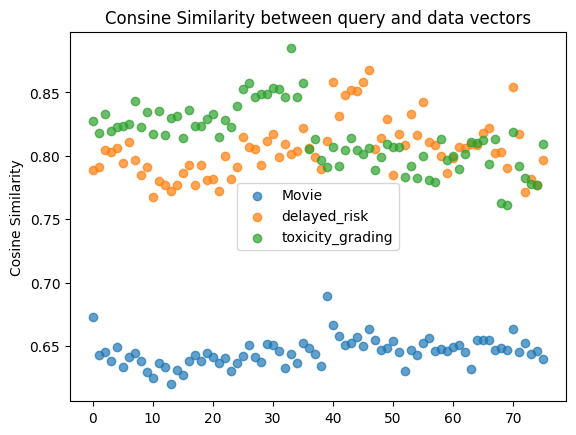

In [24]:
x = np.arange(len(data_vectors))

plt.scatter(x, cosine_sims_1, label='Movie', alpha=0.7)
plt.scatter(x, cosine_sims_2, label='delayed_risk', alpha=0.7)
plt.scatter(x, cosine_sims_3, label='toxicity_grading', alpha=0.7)

plt.ylabel('Cosine Similarity')
plt.title('Consine Similarity between query and data vectors')
plt.legend()

plt.show()

In [25]:
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

child_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=20)
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=20)
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)

In [27]:
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them. Vector stores can be used as the backbone of a retriever, but there are other types of retrievers as well.

In [29]:
retriever.add_documents(docs, ids=None)

In [30]:
retriever.__dir__()

['tags',
 'metadata',
 'vectorstore',
 'docstore',
 'id_key',
 'search_kwargs',
 'search_type',
 'child_splitter',
 'parent_splitter',
 '__config__',
 '__fields__',
 '__exclude_fields__',
 '__include_fields__',
 '__validators__',
 '__pre_root_validators__',
 '__post_root_validators__',
 '__schema_cache__',
 '__json_encoder__',
 '__custom_root_type__',
 '__private_attributes__',
 '__slots__',
 '__hash__',
 '__class_vars__',
 '__module__',
 '__annotations__',
 '__doc__',
 'add_documents',
 '__parameters__',
 '_new_arg_supported',
 '_expects_other_args',
 '__abstractmethods__',
 '_abc_impl',
 '__signature__',
 '_get_relevant_documents',
 'Config',
 '__init_subclass__',
 'invoke',
 'ainvoke',
 '_aget_relevant_documents',
 'get_relevant_documents',
 'aget_relevant_documents',
 '__orig_bases__',
 'configurable_fields',
 'configurable_alternatives',
 '__weakref__',
 'is_lc_serializable',
 'get_lc_namespace',
 'lc_secrets',
 'lc_attributes',
 'lc_id',
 '__repr_args__',
 '__init__',
 'to_json',

In [33]:
question = "What is the framework to assess delayed risks of Gene Therapies?"

In [32]:
pretty_print_docs(vectorstore.similarity_search(question))

Document 1:
GENE THERAPY CLINICAL TRIALS  
 
A. Framework  to Assess Potential Delayed Risks of Gene Therapy Prod ucts
----------------------------------------------------------------------------------------------------
Document 2:
Figure 1.  Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events
----------------------------------------------------------------------------------------------------
Document 3:
A. Criteria to Assess Potential Delayed Risks of Gene Therapy Products  ........... 5
----------------------------------------------------------------------------------------------------
Document 4:
A. Potential Risks of Delayed Adverse Events Following Exposure to Human Gene Therapy  Products


In [34]:
pretty_print_docs(retriever.get_relevant_documents(question))

Document 1:
basic and translational knowledge generated in  the field, and the product -specific 
preclinical data generated to enable investigation al new drug application ( IND) studies, 
as described in the following section.  
  IV. PRECLINICAL DATA USED FOR ASSESS MENT OF DELAYED RISK S IN 
GENE THERAPY CLINICAL TRIALS  
 
A. Framework  to Assess Potential Delayed Risks of Gene Therapy Prod ucts
----------------------------------------------------------------------------------------------------
Document 2:
Figure 1.  Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events  
 
 
1 If you have evidence that suggests that the product may integrate or if the product was intentionally  
designed to facilitate integration (please refer to Table 1, section IV.C of this document); the answer is 
“yes.”
----------------------------------------------------------------------------------------------------
Document 3:
D. Long Term Follow -up for Novel Gene Th erapy Product

### MultiQueryRetriever

Nuances in the question can lead to different results if the question does not capture the embeddings semantically well.
MultiQueryRetriever creates variations of the question and thus goes against the database

In [35]:
vectorstore.as_retriever()

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain.vectorstores.chroma.Chroma object at 0x7effd7a1eca0>)

In [37]:
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

llm = ChatOpenAI(
        temperature=0,
        max_tokens=800,
        model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
    )


retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
)

In [66]:
#retriever

In [48]:
retriever.retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain.vectorstores.chroma.Chroma object at 0x7effd7a1eca0>)

In [43]:
unique_docs = retriever.get_relevant_documents("What is the framework to assess delayed risks of Gene Therapies?")
len(unique_docs)

5

In [51]:
from typing import List

from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field


class LineList(BaseModel):
    lines: List[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        lines = text.strip().split("\n")
        return LineList(lines=lines)


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT, output_parser=output_parser)

In [52]:
llm_chain.invoke("What is the framework to assess delayed risks of Gene Therapies?")

{'question': 'What is the framework to assess delayed risks of Gene Therapies?',
 'text': LineList(lines=['1. How can we evaluate the potential risks that may arise later from Gene Therapies?', '2. What methods or tools are available to assess the long-term risks associated with Gene Therapies?', '3. Are there any frameworks specifically designed to evaluate delayed risks of Gene Therapies?', '4. How do we measure the potential long-term hazards of Gene Therapies?', '5. What approaches can be used to analyze the delayed risks of Gene Therapies?'])}

In [53]:
question = "What is the framework to assess delayed risks of Gene Therapies?"

### Contextual Compression

To use the Contextual Compression Retriever, you need:

    a basic retriever
    a document compressor

The Contextual Compression Retriever passes queries to the Base Retriever, takes the source documents and forwards them to the Document Compressor. The document compressor takes a list of documents and shortens them by reducing the content of documents or omitting documents altogether.

In [54]:
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever()

In [55]:
retriever.get_relevant_documents(query=question)

[Document(page_content='GENE THERAPY CLINICAL TRIALS  \n \nA. Framework  to Assess Potential Delayed Risks of Gene Therapy Prod ucts', metadata={'doc_id': '0fb3f60a-f8b4-4b0b-92b4-3e32bd78b393', 'page': 6, 'source': './fda_guidelines/Long-Term-Follow-Up-After-Admin-Human-GT-Products_Jan_2020.pdf'}),
 Document(page_content='Figure 1.  Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events', metadata={'doc_id': 'bfa7fc17-5d01-4a7d-9db7-9906a44cd36e', 'page': 7, 'source': './fda_guidelines/Long-Term-Follow-Up-After-Admin-Human-GT-Products_Jan_2020.pdf'}),
 Document(page_content='A. Criteria to Assess Potential Delayed Risks of Gene Therapy Products  ........... 5', metadata={'doc_id': '19244925-6ac4-4670-96bf-2f62e29c1ab3', 'page': 1, 'source': './fda_guidelines/Long-Term-Follow-Up-After-Admin-Human-GT-Products_Jan_2020.pdf'}),
 Document(page_content='A. Potential Risks of Delayed Adverse Events Following Exposure to Human Gene Therapy  Products', metadata={'doc_id':

In [56]:
# option 1 - compression of the docs using LLM. Powerful but expensive
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:
A. Framework to Assess Potential Delayed Risks of Gene Therapy Products
----------------------------------------------------------------------------------------------------
Document 2:
Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events
----------------------------------------------------------------------------------------------------
Document 3:
A. Criteria to Assess Potential Delayed Risks of Gene Therapy Products
----------------------------------------------------------------------------------------------------
Document 4:
Potential Risks of Delayed Adverse Events Following Exposure to Human Gene Therapy Products


In [58]:
# Option 2 - Filtering based on similarity threshold
# here as we select 0.9 as the threshold, we only get 2 docs
# be careful with this approach. High threshold can return empty results, low can have no impact
# cheaper compared to approach listed above (llm-based) but might not be as effective
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.9)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
GENE THERAPY CLINICAL TRIALS  
 
A. Framework  to Assess Potential Delayed Risks of Gene Therapy Prod ucts
----------------------------------------------------------------------------------------------------
Document 2:
Figure 1.  Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events


In [61]:
# Option 3 - MultiStep compressor

from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
# remove redundant documents
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
# applies similarity threshold
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.9)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
GENE THERAPY CLINICAL TRIALS  
 
A. Framework  to Assess Potential Delayed Risks of Gene Therapy Prod ucts
----------------------------------------------------------------------------------------------------
Document 2:
Figure 1.  Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events


### Ensemble Retriever

In [63]:
!pip install rank_BM25

  Using cached rank_bm25-0.2.2-py3-none-any.whl (8.6 kB)


In [64]:
# uses multiple algorithms to retrieve the best documents
# essentially this is a hybrid approach which uses both keyword-search with vector search
from langchain.retrievers import BM25Retriever, EnsembleRetriever


bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2

chroma_vectorstore = Chroma.from_documents(docs, embedding)
chroma_retriever = chroma_vectorstore.as_retriever()

# we can pass multiple retrievers and also select weights
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)

In [65]:
docs = ensemble_retriever.get_relevant_documents(query=question)
docs

[Document(page_content='Contains Nonbinding Recommendations  \n \n6 GT product knowledge is critical in assessing  the level of risk  for delayed adverse events \nand the need for LTFU observations.  To help you in this process, we refer you to s ection \nIII.A of this document , and to the series  of questions in Figure 1, “Framework to Assess \nthe Risk of Gene Therapy -Related Delayed Adverse Events .” \n \nFigure 1.  Framework to Assess the Risk of Gene Therapy -Related Delayed Adverse Events  \n \n \n1 If you have evidence that suggests that the product may integrate or if the product was intentionally  \ndesigned to facilitate integration (please refer to Table 1, section IV.C of this document); the answer is \n“yes.”  \n2 See section V. of the text for recommendations on how to perform clinical LTFU observations.  \n \nNote, that e vidence from preclinical studies will help you answer questions 3 thr ough 5 \nbelow  and in Figure 1.  When the risk of delayed adverse events is lo

### Self-Querying retriever

Metadata of the document can be used for better retrieval

A self-querying retriever is a retriever that, as the name suggests, has the ability to 
the ability to query itself. More precisely, any natural language query,
 the retriever uses an LLM chain for query construction to write a structured query
 structured query and then applies this structured query to the underlying 
VectorStore. This allows the retriever to not only use the query entered by the user 
query for the semantic similarity comparison with the content of the stored 
documents, but also apply filters from the user query to the metadata of the stored 
metadata of the stored documents and execute these filters.

In [ ]:
from langchain.schema import Document
from langchain.vectorstores import Chroma

docs = [
    Document(
        page_content="Bello-Basistraining offers a comprehensive foundation for dog obedience, focusing on basic commands and socialization.",
        metadata={"type": "Basic Training", "feature": "Foundational Skills", "price": "Affordable"},
    ),
    Document(
        page_content="Pfote-Agilitykurs provides a fun and energetic way to keep dogs fit and mentally stimulated through obstacle courses.",
        metadata={"type": "Agility Training", "feature": "Physical Fitness", "price": "Moderate"},
    ),
    Document(
        page_content="Wuff-Verhaltensberatung specializes in addressing behavioral issues, offering tailored strategies for each dog.",
        metadata={"type": "Behavioral Consultation", "feature": "Customized Solutions", "price": "Premium"},
    ),
    Document(
        page_content="Schwanzwedeln-Therapiehundausbildung prepares dogs for roles in therapeutic and support settings, focusing on empathy and gentleness.",
        metadata={"type": "Therapy Dog Training", "feature": "Emotional Support", "price": "High"},
    ),
    Document(
        page_content="Schnüffler-Suchhundetraining trains dogs in scent detection, useful for search and rescue operations.",
        metadata={"type": "Search and Rescue Training", "feature": "Advanced Skills", "price": "Variable"},
    ),
    Document(
        page_content="Hunde-Haftpflichtversicherung offers comprehensive coverage for potential damages or injuries caused by your dog.",
        metadata={"type": "Dog Liability Insurance", "feature": "Financial Protection", "price": "Varies"},
    ),
]

vectorstore = Chroma.from_documents(docs, embedding)


In [ ]:
from langchain.vectorstores import Chroma
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="type",
        description="The type of dog training service (e.g., Basic Training, Agility Training, Behavioral Consultation)",
        type="string",
    ),
    AttributeInfo(
        name="feature",
        description="Special features or benefits of the service",
        type="string",
    ),
    AttributeInfo(
        name="price",
        description="Price category of the service (e.g., Affordable, Moderate, Premium)",
        type="string",
    ),
]

document_content_description = "Description of a dog training service"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)


In [ ]:
retriever.invoke("What Premium priced trainings do you offer?")

### Time-weighted vector store retriever

In [ ]:
import faiss

from datetime import datetime, timedelta
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.schema import Document
from langchain.vectorstores import FAISS

In [ ]:

# decay_rate = .0000000000000000000000001
decay_rate = .999

embedding_size = 1536
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(embedding, index, InMemoryDocstore({}), {})
retriever = TimeWeightedVectorStoreRetriever(vectorstore=vectorstore, decay_rate=decay_rate, k=1)

In [ ]:
yesterday = datetime.now() - timedelta(days=1)
retriever.add_documents([Document(page_content="hello world", metadata={"last_accessed_at": yesterday})])
retriever.add_documents([Document(page_content="hello foo")])

In [ ]:
retriever.get_relevant_documents("hello world")